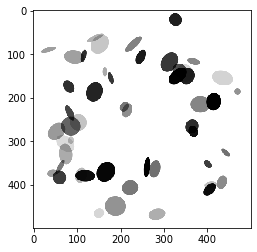

In [1]:
#pyright: reportGeneralTypeIssues=false
from math import atan, cos, sin, tan
import typing

import torch
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np

def gen_ellipses(img_size: int, ellipses_count: int, ellipses_size: float, ellipses_size_min: float=1) -> torch.Tensor:
    old_be = matplotlib.get_backend()
    matplotlib.use("Agg")
    fig = plt.figure(figsize=(img_size,img_size), dpi=1)
    ax = fig.add_axes([0.0,0.0,1.0,1.0])
    ellipse_func = lambda w, h, a, t: (w/2.0*cos(t)*cos(a)-h/2.0*sin(t)*sin(a), w/2.0*cos(t)*sin(a)+h/2.0*sin(t)*cos(a))
    for _ in range(ellipses_count):
        ellipse_width_aa = np.random.rand()*max(0.0, ellipses_size-ellipses_size_min)+ellipses_size_min
        ellipse_height_aa = np.random.rand()*max(0.0, ellipses_size-ellipses_size_min)+ellipses_size_min
        ellipse_angle = np.random.rand()*360.0
        args = (ellipse_width_aa, ellipse_height_aa, ellipse_angle/180.0*np.pi)
        t = atan(-ellipse_height_aa*tan(ellipse_angle/180.0*np.pi)/ellipse_width_aa)
        ellipse_width = max(ellipse_func(*args, t)[0], ellipse_func(*args, t+np.pi)[0])-min(ellipse_func(*args, t)[0], ellipse_func(*args, t+np.pi)[0])
        t = atan(ellipse_height_aa/(tan(ellipse_angle/180.0*np.pi)*ellipse_width_aa))
        ellipse_height = max(ellipse_func(*args, t)[1], ellipse_func(*args, t+np.pi)[1])-min(ellipse_func(*args, t)[1], ellipse_func(*args, t+np.pi)[1])
        ellipse_x = ellipse_width/2.0+np.random.rand()*(img_size-ellipse_width)
        ellipse_y = ellipse_height/2.0+np.random.rand()*(img_size-ellipse_height)
        ellipse = matplotlib.patches.Ellipse(xy=[ellipse_x, ellipse_y], width=ellipse_width_aa, height=ellipse_height_aa, angle=ellipse_angle)
        ax.add_artist(ellipse)
        ellipse.set_clip_box(ax.bbox)
        ellipse.set_alpha(0.1+0.9*np.random.rand())
    ax.axis("off")
    ax.set_xlim(0.0, img_size)
    ax.set_ylim(0.0, img_size)
    fig.add_axes(ax)
    fig.canvas.draw()
    img = torch.from_numpy(1.0-np.array(fig.canvas.renderer._renderer)[:,:,3])
    #img = torch.from_numpy(np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).copy())
    #img = torch.swapaxes(img.reshape(img_size,img_size,4), 0, 2)
    #img = 1.0-img.to(torch.float32)/255.0
    plt.close()
    matplotlib.use(old_be)
    return img

plt.figure()
plt.imshow(gen_ellipses(500, 50, 50, 10), interpolation="none", cmap="gray")
plt.show()

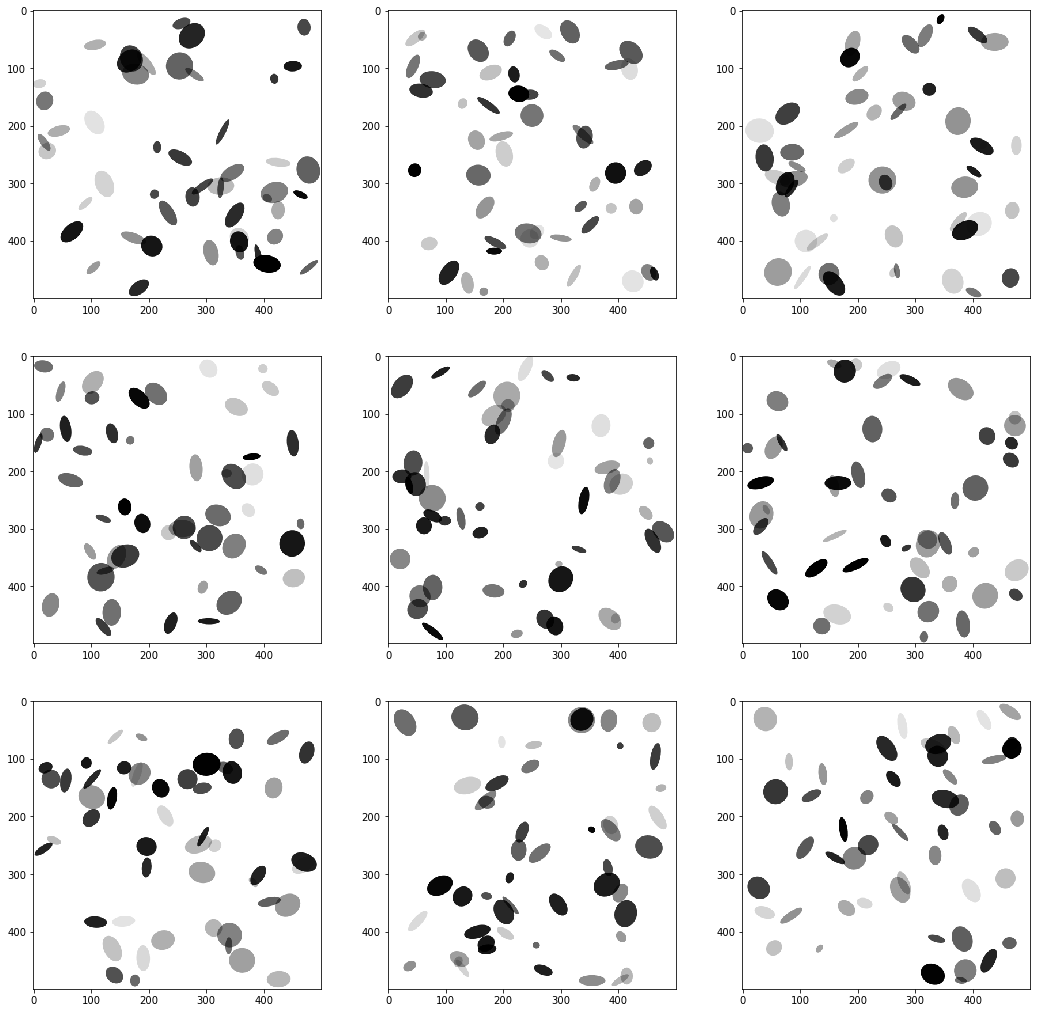

In [2]:
import omegaconf
from ellipses_datamodule import EllipsesDataModule

torch.manual_seed(1)
tdmi = iter(EllipsesDataModule(typing.cast(omegaconf.DictConfig, type("",(object,), {
    "img_size": 500, 
    "training_batch_count": -1, 
    "training_batch_size": 32, 
    "drop_last_training_batch": True, 
    "shuffle_training_data": False, 
    "num_workers": 0,
    "ellipse_count": 50,
    "ellipse_size": 50,
    "ellipse_size_min": 10
})())).train_dataloader())
plt.subplots(3,3,figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(next(tdmi)[0,0], interpolation="none", cmap="gray")
plt.show()